# 5. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                       noise=0.03,
                       random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


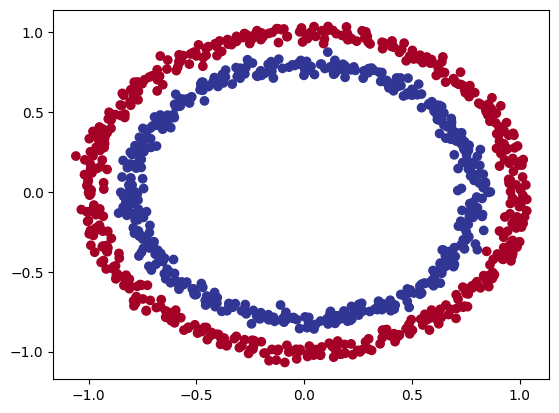

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y, # color with labels
            cmap=plt.cm.RdYlBu)
plt.show()

**NOTE:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

`Refer`: https://scikit-learn.org/stable/datasets/toy_dataset.html

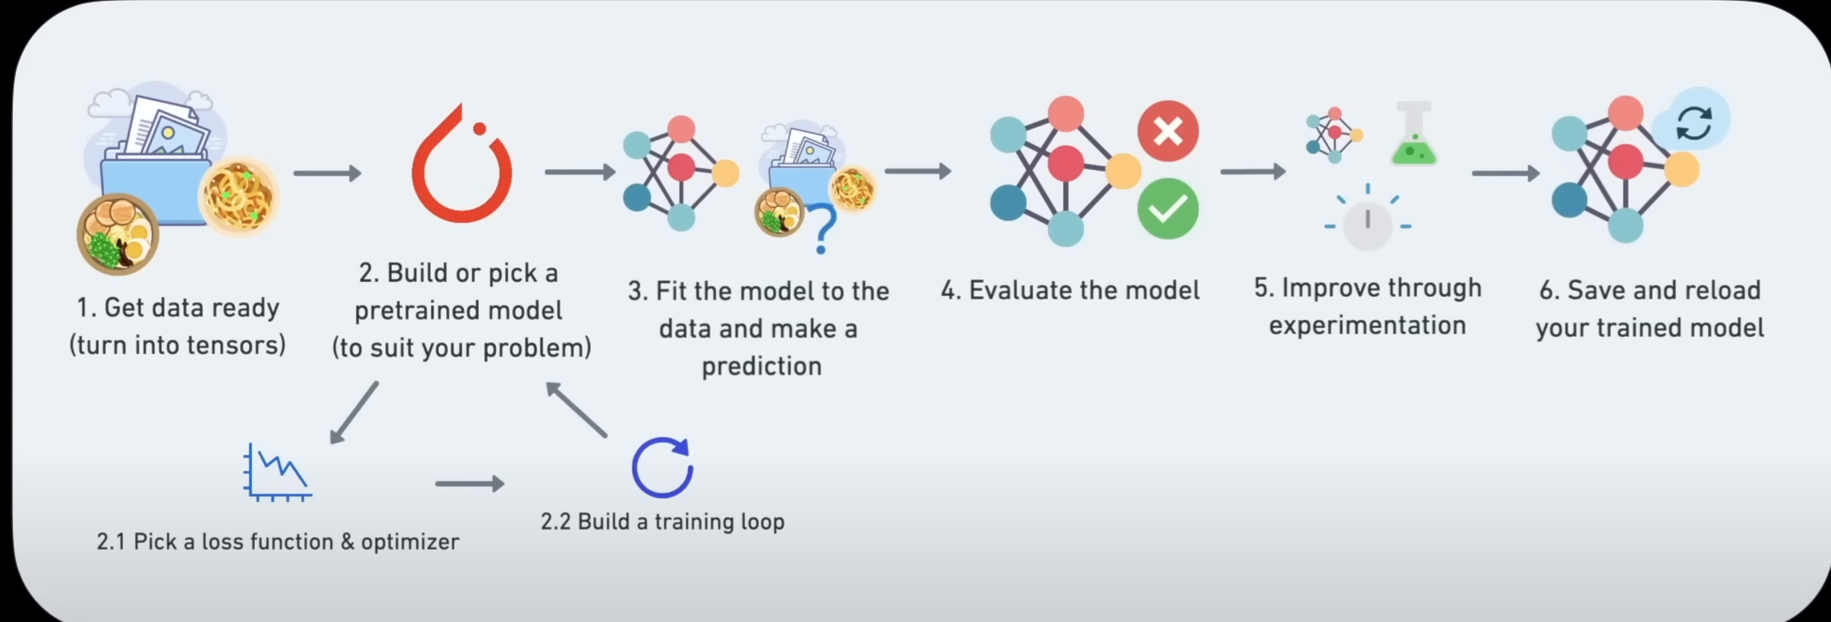

## 1.1 Check input and output shapes.

In [ ]:
X.shape, y.shape  # 1000 samples of X, 1000 samples of y, 2 samples of X equal to 1 y label

((1000, 2), (1000,))

In [ ]:
# View the first example of the features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train-test split

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# Turn data into tensors - PyTorch default - float32
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split data into training and tets sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,   # 0.2 = 20% of data will be test & 80% will be train.
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code runs on an accelerator (GPU) if available.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer.
4. Create a training and testing loop.

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup the deivce agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instantiate an instance of our model class and send it to the target `device`.

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
y_train.shape

torch.Size([800])

In [ ]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [ ]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [ ]:
# (1st method)
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from the previous layer and outputs a single feature (same shape as y).
    # in_features -> X_train shape samples which is 2 and y_train -> y_sample (label shape) which is 1


  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x))   # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to ou target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# (2nd method)
'''
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 5),
        nn.Linear(in_features = 5, out_features = 1)
    )

  def forward(self, x):
    return self.two_linear_layers(x)

model_0 = CircleModelV0().to(device)
model_0
'''

In [ ]:
# Let's replicate the model_0 we coded above using nn.Sequential() -> 2nd way
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1430,  0.5549],
                      [ 0.3766, -0.5406],
                      [ 0.0650, -0.4956],
                      [-0.1994,  0.3176],
                      [-0.6422,  0.3409]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.3765, -0.6469,  0.3382,  0.4642, -0.1889], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1428,  0.3915,  0.4163,  0.0895, -0.1405]], device='cuda:0')),
             ('1.bias', tensor([-0.2008], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}") # out_features=1: The model outputs a single value (logit or probability) for each input sample.
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")  # X_test contains 20% of samples, i.e., 200 rows (samples). Each row still has 2 features. Thus, shape of X_test is [200, 2].
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [ 0.],
        [ 0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 2.1 Setup loss function and optimizer
Which loss function or optimizer should you use?
Again.. this is problem specific.

For example, for regression you might want to use MAE or MSE.

For Classification you might want to use Binary Cross Entropy (BCE) or Categorical Cross Entropy (CCE).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what Binary Cross Entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723

* For different optimizers see `torch.optim`


### **1. Logits**

- **Definition**:  
  Logits are the **raw, unnormalized scores or predictions** output by the last layer of a neural network, typically before applying an activation function like `softmax`.
  
- **Range**:  
  Logits can take any value, positive or negative (-infinity, infinity).

- **Usage**:  
  Logits are often used as input to the `softmax` function to produce probabilities for multi-class classification.

- **Example**:
  ```
  logits = torch.tensor([2.0, 1.0, 0.1])
  ```
  Here, the logits represent unnormalized scores for three classes.

---

### **2. Softmax**

- **Definition**:  
  The **softmax function** converts logits into probabilities. It ensures that:
  1. All probabilities are in the range [0, 1].
  2. The sum of probabilities across all classes equals 1.

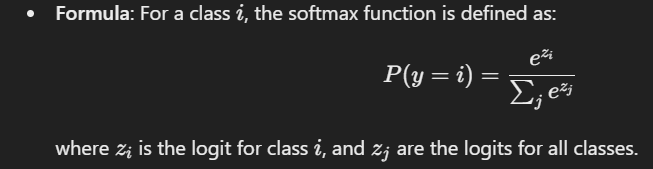

- **Purpose**:
  - Softmax outputs are interpretable as probabilities for multi-class classification tasks.
  - It allows comparison between classes.

- **Example**:
  ```
  logits = torch.tensor([2.0, 1.0, 0.1])
  probs = torch.nn.functional.softmax(logits, dim=0)
  print(probs)  # Output: tensor([0.6590, 0.2424, 0.0986])
  ```
  The highest probability corresponds to the first class.

---

### **3. Argmax**

- **Definition**:  
  `argmax` finds the **index of the maximum value** in a tensor or array.

- **Usage**:  
  After applying `softmax`, you can use `argmax` to determine the class with the highest probability (i.e., the predicted class).

- **Example**:
  ```
  probs = torch.tensor([0.6590, 0.2424, 0.0986])
  prediction = torch.argmax(probs)
  print(prediction)  # Output: 0
  ```
  This indicates that the first class is the predicted class.

---

### **How They Work Together**

In a classification model, the workflow typically involves:
1. **Logits**: The model outputs raw scores (logits).
2. **Softmax**: The logits are converted into probabilities.
3. **Argmax**: The class with the highest probability is selected as the prediction.

---

### **Practical Code Example**
```python
import torch
from torch.nn.functional import softmax

# Example logits (raw scores)
logits = torch.tensor([2.0, 1.0, 0.1])

# Apply softmax to convert logits to probabilities
probs = softmax(logits, dim=0)
print("Probabilities:", probs)  # tensor([0.6590, 0.2424, 0.0986])

# Use argmax to find the predicted class
prediction = torch.argmax(probs)
print("Predicted class:", prediction)  # Output: 0 (first class)
```

---

### **Key Points**

- **Logits** are raw scores output by the model.
- **Softmax** normalizes logits into probabilities.
- **Argmax** selects the index of the class with the highest probability.


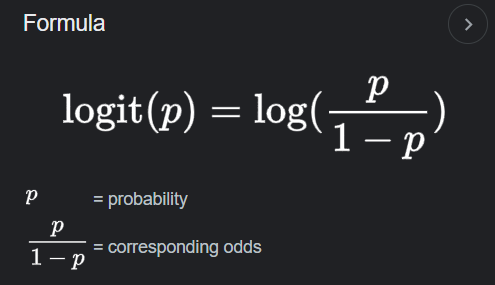

In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
# Instead of using a sigmoid followed by a BCELoss like in above lines in this cell, we can rather go for BCEWithLogitsLoss() which is more numerically stable.
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss() = Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### **Understanding `BCEWithLogitsLoss`**

`BCEWithLogitsLoss` in PyTorch is a loss function that combines the **Binary Cross-Entropy (BCE) loss** with the application of the **sigmoid activation function** in one step. This is commonly used for **binary classification** tasks or multi-label classification problems.

---

### **What Does `BCEWithLogitsLoss` Do?**
- It **automatically applies the sigmoid activation function** to the logits before calculating the binary cross-entropy loss.
- This avoids numerical instability issues that might arise when manually applying `sigmoid` followed by `BCELoss`.

---

### **Why Combine Sigmoid and BCE?**
- **Numerical Stability**:  
  When logits are very large (positive or negative), applying the sigmoid first can cause numerical issues (e.g., overflow or underflow). By combining these steps internally, `BCEWithLogitsLoss` handles this more efficiently.
- **Convenience**:  
  You don’t have to explicitly apply the `sigmoid` function in your model or pipeline.

---

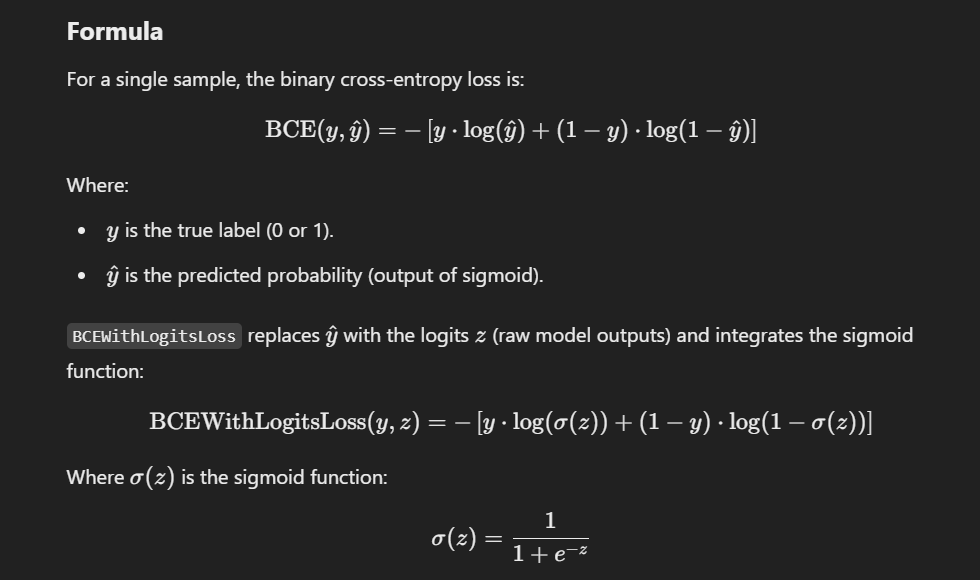

---

### **Arguments**
`BCEWithLogitsLoss` has the following main arguments:
1. **`pos_weight`** *(optional)*:  
   - Adjusts the weight for positive classes to handle class imbalance.
   - If `pos_weight > 1`, the loss penalizes false negatives more.
   - For example, in imbalanced datasets where positive samples are rare, use `pos_weight` to emphasize them.

2. **Reduction** *(default = 'mean')*:  
   - `'mean'`: Averages the loss across all samples.
   - `'sum'`: Sums the loss across all samples.
   - `'none'`: Returns the loss for each sample without reduction.

---

### **Use Case: Binary Classification**
When using `BCEWithLogitsLoss`, the model outputs **logits** (raw scores). These logits are passed directly to `BCEWithLogitsLoss`, which applies the sigmoid activation internally.

---

### **Example Code**

#### Binary Classification Example:
```python
import torch
from torch import nn

# Define logits (raw outputs from a model)
logits = torch.tensor([0.2, -1.5, 3.0])  # Predictions (before sigmoid)
targets = torch.tensor([1.0, 0.0, 1.0])  # True labels (binary)

# Initialize the BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss()

# Calculate the loss
loss = loss_fn(logits, targets)
print("Loss:", loss.item())
```

---

#### Multi-Label Classification Example:
```python
# Example with multi-label classification (logits per class)
logits = torch.tensor([[0.8, -1.2], [2.5, -0.5]])  # Shape: [batch_size(no. of samples in a batch, here 2 rows so 2), num_classes(no. of output classes, 2 columns in tensor)]
targets = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Corresponding labels

loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logits, targets)
print("Loss:", loss.item())
```

---

### **Key Benefits**
1. **Efficient & Stable**:  
   Combines sigmoid and BCE for better numerical stability.
2. **Versatile**:  
   Can be used for both binary and multi-label classification tasks.
3. **Class Imbalance Handling**:  
   The `pos_weight` argument makes it easy to handle class imbalance.

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()  # before applying item() output till sum will be tensor(), after that we get a numerical value (Python integer)
  acc=(correct/len(y_pred))*100
  return acc

## 3. Train
To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad (zero gradients)
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits** which are not passed to any activation function.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of **activation function** (e.g. *sigmoid* for binary classification and *softmax* for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking them or taking the `argmax()`.

So *round* is for binary classification and *argmax* is for the outputs of the softmax activation.

In [ ]:
# View the first 5 outputs of the forward pass on the test data - prediction
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5209],
        [-0.5319],
        [-0.2378],
        [-0.6022],
        [ 0.1661]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3726],
        [0.3701],
        [0.4408],
        [0.3538],
        [0.5414]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y`=1 (class=1)
* `y_pred_probs` < 0.5, `y`=0 (class=0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Both y_preds and y_pred_labels are same (they have the same formula)
# This is done mainly because we have used nn.BCEWithLogitsLoss()

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs=100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and testing loop
for epoch in range(epochs+1):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  # In loss functions predictions(y_logits) come first and then the true labels(y_train)
  # loss = loss_fn(torch.sigmoid(y_logits),    # nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits,          # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  # In accuracy function true labels come first and then the predictions (opposite of the loss function)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70809, Acc: 47.75% | test loss: 0.70106, Test acc: 48.50%
Epoch: 10 | Loss: 0.70085, Acc: 48.00% | test loss: 0.69544, Test acc: 51.50%
Epoch: 20 | Loss: 0.69774, Acc: 49.00% | test loss: 0.69347, Test acc: 51.00%
Epoch: 30 | Loss: 0.69615, Acc: 49.38% | test loss: 0.69276, Test acc: 51.00%
Epoch: 40 | Loss: 0.69521, Acc: 49.88% | test loss: 0.69251, Test acc: 48.00%
Epoch: 50 | Loss: 0.69459, Acc: 50.50% | test loss: 0.69246, Test acc: 48.50%
Epoch: 60 | Loss: 0.69417, Acc: 50.75% | test loss: 0.69250, Test acc: 48.50%
Epoch: 70 | Loss: 0.69386, Acc: 51.00% | test loss: 0.69258, Test acc: 48.00%
Epoch: 80 | Loss: 0.69364, Acc: 50.62% | test loss: 0.69269, Test acc: 48.50%
Epoch: 90 | Loss: 0.69348, Acc: 51.25% | test loss: 0.69281, Test acc: 48.50%
Epoch: 100 | Loss: 0.69337, Acc: 51.00% | test loss: 0.69293, Test acc: 50.00%


## 4. Make predictions and evaluate the model

### importing plot_decision_boundary()
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual.

In other words, "visualize, visualize, visualize!!!"

To do so, we're going to import a function called `plot_decision_boundary()`.

Please refer:

* [https://madewithml.com/courses/foundations/neural-networks/](https://madewithml.com/courses/foundations/neural-networks/)
* [https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py)


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


```python
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})
```

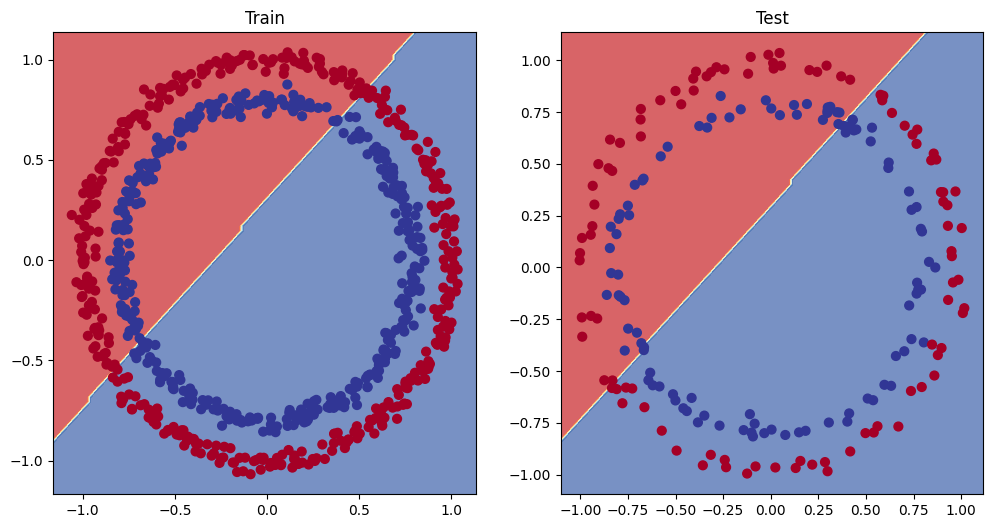

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)           # (rows, col, index)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### **1. Logits**
- **Definition**: The raw, unnormalized output of a model before applying any activation function (e.g., sigmoid or softmax).
- **Range**: (-∞, +∞)
- **Purpose**: Logits represent the raw score for each class and are used internally for calculating loss functions (like BCEWithLogitsLoss or CrossEntropyLoss). They make optimization more numerically stable.
  
#### Example:
For binary classification:
- A **positive logit** implies a prediction favoring Class 1.
- A **negative logit** implies a prediction favoring Class 0.

---

### **2. Predicted Probabilities (Pred Probs)**
- **Definition**: The normalized output after applying an activation function (like sigmoid or softmax) to the logits. These represent the model's confidence about each class.
- **Range**: [0, 1]
- **Purpose**: Probabilities are interpretable as confidence scores. For binary classification:
  - Probability close to 1 → Strong confidence for Class 1.
  - Probability close to 0 → Strong confidence for Class 0.

#### For Binary Classification:
P(y = 1 | x) = Sigmoid(logit) = 1 / (1 + e^-logit)
---

### **3. Predicted Labels (Pred Labels)**
- **Definition**: The final class assignment based on the predicted probabilities and a threshold.
- **Range**: {0, 1} (binary classification) or {0, 1, 2, ....C-1} (multi-class classification with C classes).
- **Purpose**: Labels are used to evaluate the model's predictions against the ground truth (e.g., for accuracy calculation).

#### Threshold:
- For binary classification, **0.5** is the default threshold:
  - {Pred Label} = 1) if {Pred Prob} >= 0.5)
  - {Pred Label} = 0) if {Pred Prob} < 0.5)

---

### **Example (Binary Classification):**
```python
import torch

logits = torch.tensor([-2.0, 0.0, 1.0, 4.0])  # Raw outputs
pred_probs = torch.sigmoid(logits)            # Convert to probabilities
pred_labels = (pred_probs >= 0.5).int()       # Convert to labels (default threshold: 0.5)

print("Logits:       ", logits)
print("Pred Probs:   ", pred_probs)
print("Pred Labels:  ", pred_labels)
```

#### Output:
```
Logits:        tensor([-2.,  0.,  1.,  4.])
Pred Probs:    tensor([0.1192, 0.5000, 0.7311, 0.9820])
Pred Labels:   tensor([0, 1, 1, 1])
```

---

### **Comparison:**
| **Term**              | **Range**          | **Purpose**                                                   | **Example Value** |
|-----------------------|--------------------|-------------------------------------------------------------|-------------------|
| **Logits**            | \((-∞, +∞)\)       | Raw model outputs (before activation).                       | `1.0`, `-2.0`    |
| **Pred Probs**         | \([0, 1]\)         | Confidence score after applying sigmoid/softmax.             | `0.73`, `0.11`   |
| **Pred Labels**        | \(\{0, 1\}\)       | Final binary/multi-class prediction after thresholding.       | `1`, `0`         |


# 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units (maybe go from 5 hidden units to 10 hidden units.)
* Fit for longer - increase epochs
* Changing the activation functions.
* Changing the learning rate.
* Changing the loss function.

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data
scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units 5 -> 10
* Increase the number of layers 2 -> 3
* Increase the number of epochs 100 -> 1000

It is not advisable to change multiple hyperparameters at a time as doing so we wouldn't know which one results in the most contribution towards improvement/inefficiency.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs+1):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_pred)

  # 3. Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 1000 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


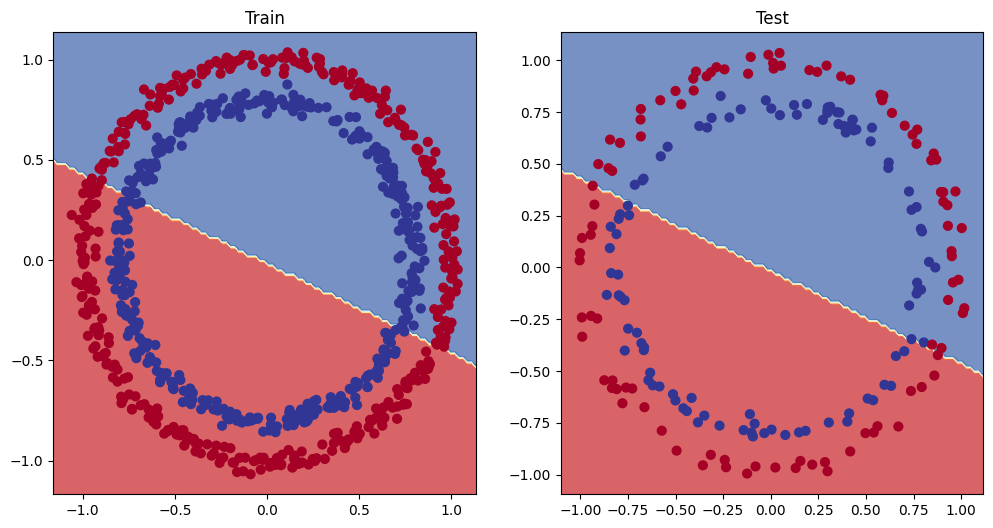

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)           # (rows, col, index)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot to a larger problem is to test out a smaller problem.

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

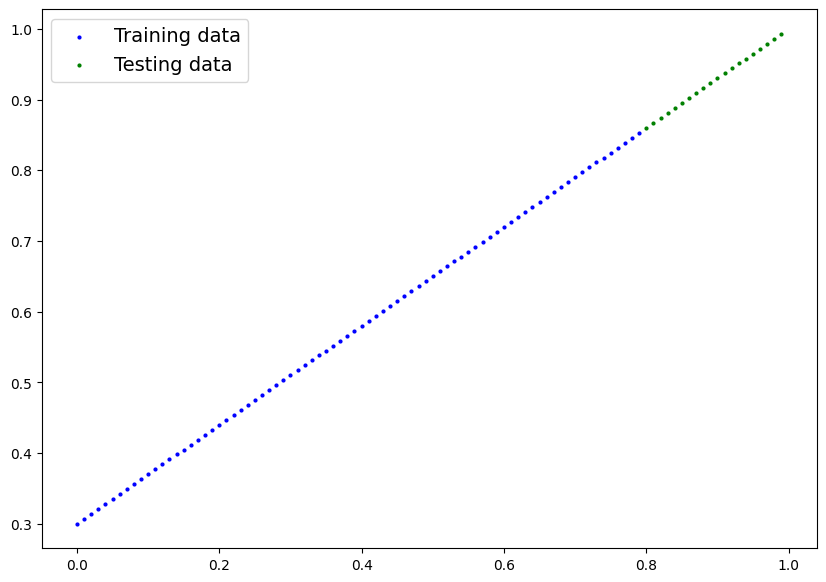

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

## 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

- `nn.L1Loss()` is used for regression tasks as it calculates the Mean Absolute Error (MAE) between predicted and target values.
  - Use it when you want a model to predict continuous numerical values and need it to be less sensitive to outliers.

- `nn.BCEWithLogitsLoss()` is used for Binary classification tasks (or multi-label classification).
  - Combines the Sigmoid activation function and Binary Cross-Entropy (BCE) loss into a single function, making it more numerically stable than using sigmoid followed by nn.BCELoss().

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()   # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs=100

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs+1):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss 0.02858 | Test loss: 0.00081


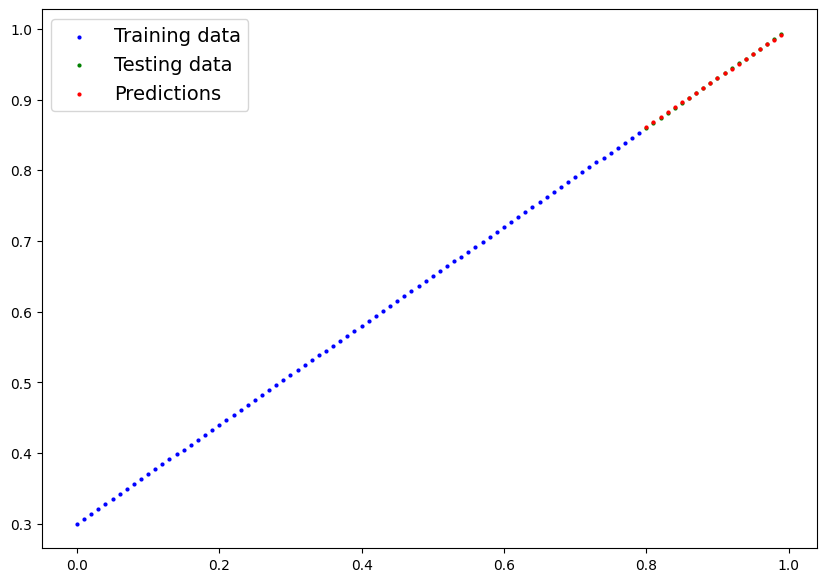

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())


# 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in ML terms, an infinite (but really it's finite) of linear and non-linear functions?

1)
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

2) https://pytorch.org/docs/stable/nn.html#non-linear-activations-other

## 6.1 Recreating non-linear data (red and blue circles)

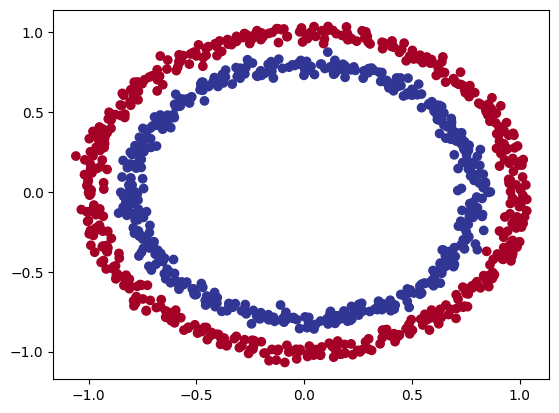

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)  # Converting to float here because it is numpy default which is being used behind the scenes in the make_circles function.
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find
patterns in data.

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()  # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linar activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

## 6.3 Training a model with non-linearity

In [ ]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs+1):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> pred probabilities -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()


  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test loss: 0.6932, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test loss: 0.6910, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test loss: 0.6894, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test loss: 0.6872, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test loss: 0.6841, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test loss: 0.6794, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test loss: 0.6729, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test loss: 0.6632, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test loss: 0.6476, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test loss: 0.6215, Test acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Acc: 87.75% | Test loss: 0.5738, Test acc: 86.50%
Epoch: 1100 | Loss: 0.4815, Acc: 93.50% | Test loss: 0.4993, Test acc: 90.50%
Epoch: 1200 | Loss: 0.3706, Acc: 97.75% | Test loss: 0.4059, Test acc: 92.00

## 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

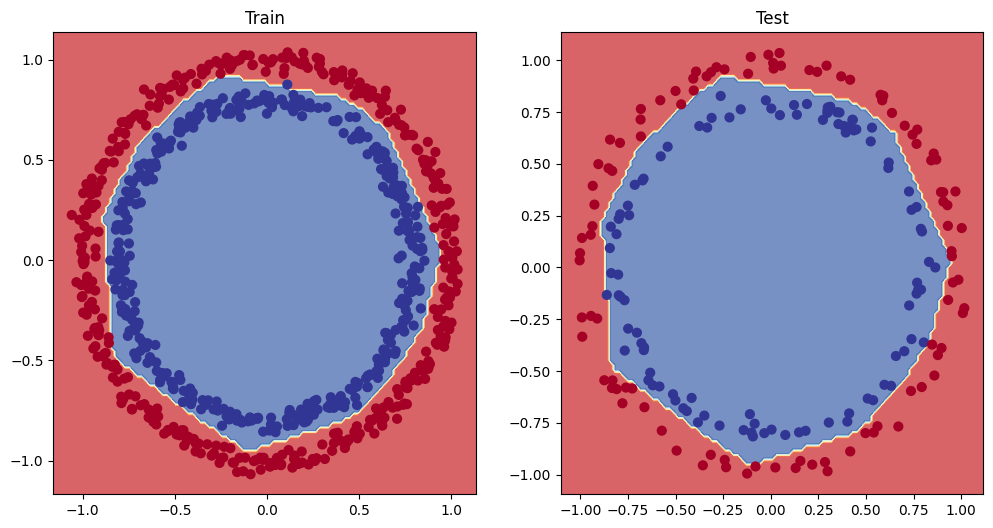

In [ ]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)         # (rows, col, index)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it tools to dicover patterns in data and it tries to figure out the best patterns on its own.

And these tools are linear and non-linear funtions.

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

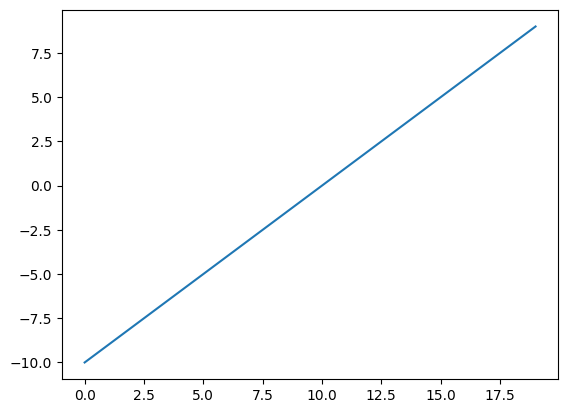

In [ ]:
# Visualize the tensor
plt.plot(A)
plt.show()

For info on relu check:

https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

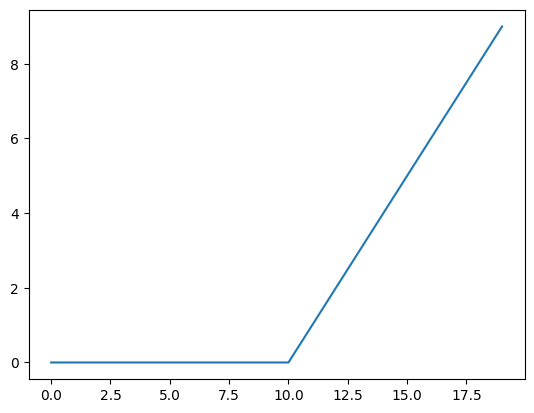

In [ ]:
plt.plot(torch.relu(A))
plt.show()

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)  # Inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

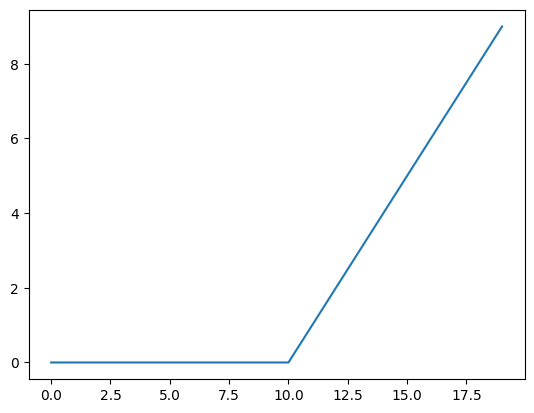

In [ ]:
# Plot relu activation function
plt.plot(relu(A))
plt.show()

Now let's do the same for sigmoid

https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

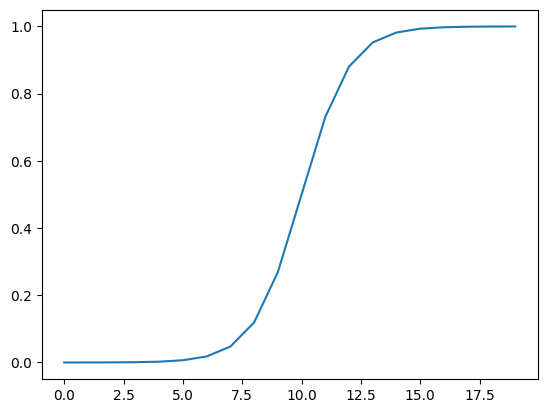

In [ ]:
plt.plot(torch.sigmoid(A))
plt.show()

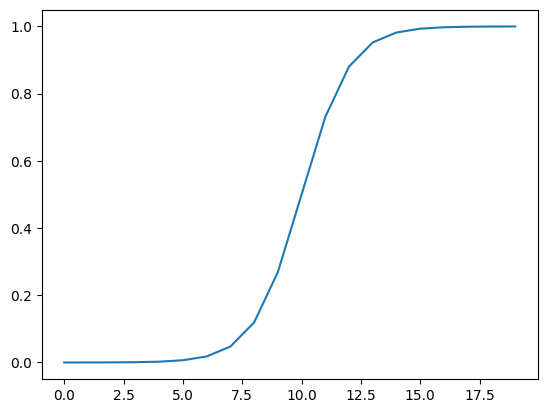

In [ ]:
plt.plot(sigmoid(A))
plt.show()

# 8. Putting it all together with a multi-class classification problem

* **Binary classification problem**: one thing or another (cat vs dog, spam vs not spam, fraud or not fraud etc)

* **Multi-class classification problem**: more than one thing or another (cat vs dog vs chicken)

## 8.1 Creating a toy multi-class dataset

### `sklearn.datasets.make_blobs`

* `n_samples`: **int or array-like, default=100**

If int, it is the total number of points equally divided among clusters. If array-like, each element of the sequence indicates the number of samples per cluster.

* `n_features`: **int, default=2**

The number of features for each sample.

* `centers`: **int or array-like of shape (n_centers, n_features), default=None**

The number of centers to generate, or the fixed center locations. If n_samples is an int and centers is None, 3 centers are generated. If n_samples is array-like, centers must be either None or an array of length equal to the length of n_samples.

* `cluster_std`: **float or array-like of float, default=1.0**

The standard deviation of the clusters.

* `center_box`: **tuple of float (min, max), default=(-10.0, 10.0)**

The bounding box for each cluster center when centers are generated at random.

* `shuffle`: **bool, default=True**

Shuffle the samples.

* `random_state`: **int, RandomState instance or None, default=None**

Determines random number generation for dataset creation. Pass an int for reproducible output across multiple function calls.

* `return_centers`: **bool, default=False**

If True, then return the centers of each cluster.

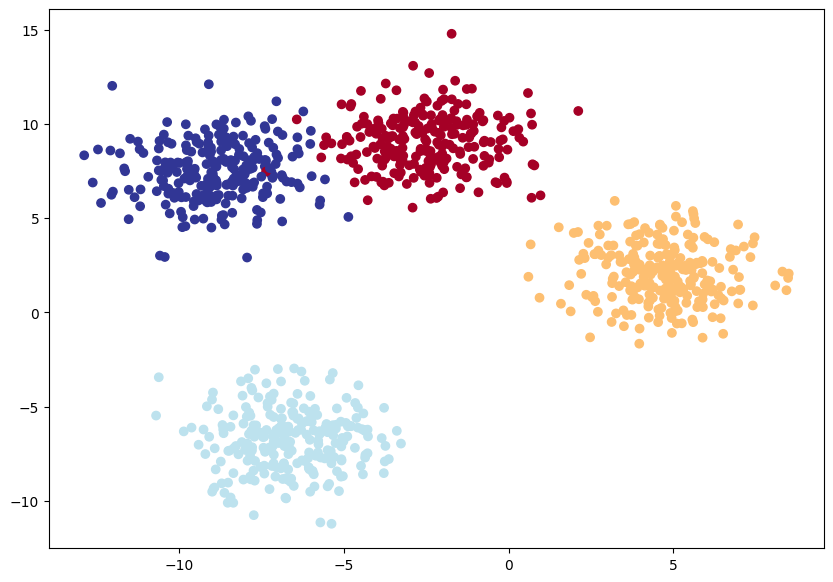

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs  # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create a multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,  # To give clusters a little shake-up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)  # "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float' error if use 'Float' instead of 'LongTensor' during training
# This is because in CrossEntropyLoss performance is generally better when target contains class indices, as this allows for optimized computation -> used LongTensor
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# 3. Split data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8. """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape

torch.Size([800, 2])

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

## 8.3 Create a loss function and an optimizer for a multi-class classification model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
# Loss function for multi-class classification - measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Optimizer for multi-class classification - updates our model's parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

## 8.4 Getting prediction probabilities for a multi-class classification PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probabilities (use `torch.softmax`) -> Pred labels (take the argmax of the pred probabilities)

**Remember:** To convert logits -> pred probabilities, we need an activation function

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

**NOTE:** *Multi-class classification uses `softmax()` activation function.*

https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 8.5 Creating a training loop and testing loop for a multi-class PyTorch classification model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs+1):
  ###Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward()
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)


  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test acc: 99.50%
Epoch: 100 | Loss: 0.0331, Acc: 99.25% | Test Loss: 0.0243, Test acc: 99.50%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6257,  6.0063, -7.6488, -8.4666],
        [-2.1813, -6.3889, -3.7303,  3.1376],
        [-3.4241, -3.9088,  3.1701, -2.6211],
        [-1.1539,  4.2110, -3.8565, -4.8926],
        [ 3.7713, -1.3379, -9.1623, -6.9665],
        [-2.8284, -7.5936, -4.3072,  3.8118],
        [-3.0427, -3.3442,  2.8070, -2.1454],
        [ 3.3902, -4.0445, -6.9149, -3.5610],
        [-4.3793, -5.0066,  3.8291, -3.3930],
        [ 3.5159, -3.0320, -7.5575, -4.7203]], device='cuda:0')

In [ ]:
# Go from logits -> pred probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3158e-03, 9.9868e-01, 1.1725e-06, 5.1754e-07],
        [4.8691e-03, 7.2458e-05, 1.0344e-03, 9.9402e-01],
        [1.3611e-03, 8.3833e-04, 9.9476e-01, 3.0383e-03],
        [4.6540e-03, 9.9492e-01, 3.1196e-04, 1.1070e-04],
        [9.9397e-01, 6.0044e-03, 2.4010e-06, 2.1578e-05],
        [1.3046e-03, 1.1117e-05, 2.9733e-04, 9.9839e-01],
        [2.8462e-03, 2.1055e-03, 9.8807e-01, 6.9819e-03],
        [9.9842e-01, 5.8947e-04, 3.3409e-05, 9.5600e-04],
        [2.7205e-04, 1.4528e-04, 9.9885e-01, 7.2945e-04],
        [9.9829e-01, 1.4306e-03, 1.5493e-05, 2.6444e-04]], device='cuda:0')

In [ ]:
# Go from pred probabilities -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

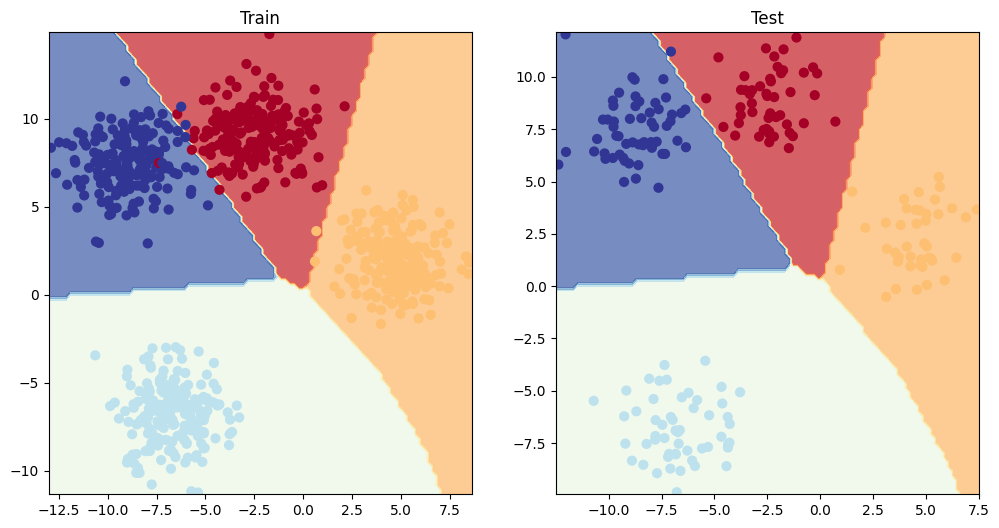

In [ ]:
# Visualizing
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# 9. A few more classification metrics...(to evaluate our classification model)

* **Accuracy** - out of 100 samples, how many does our model get right?
* **Precision**
* **Recall**
* **F1-Score**
* **Confusion Matrix**
* **Classification Report**

*See this article for precision and recall:*

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

*Precision and recall tradeoff -*

https://datascience-george.medium.com/the-precision-recall-trade-off-aa295faba140#:~:text=The%20Idea%20behind%20the%20precision,to%20decrease%2C%20or%20vice%20versa

*If you want access tot a lot of PyTorch metrics, see TorchMetrics -*
https://torchmetrics.readthedocs.io/en/latest/

Let's try out the `torchmetrics.Accuracy` metric.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

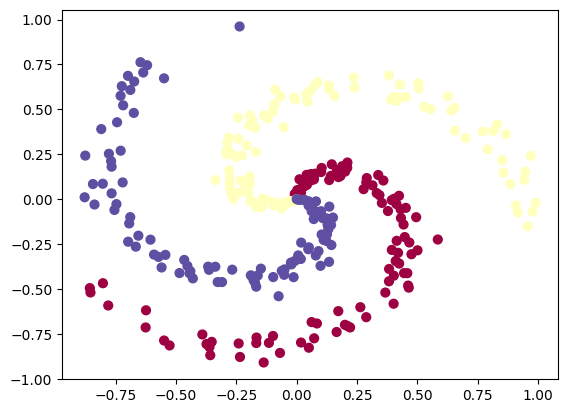

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

#### Manan Kumar